## U-Net for Navier Stokes 

In this notebook, we solve for the vorticity evolution of the 2-d Navier-Stokes equation for viscous, incompressible fluid in vorticity form using a UNet. Data information regarding the vorticity is obtained from https://github.com/oduolaidrisA/Scientific-Machine-Learning/blob/main/data_generation.ipynb.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')
import h5py

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


In [2]:
class config:
    def __init__(self):
        #The File paths
        self.data_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/ns_data.h5' #Load data 
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/ns_model.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_ns'

        #data parameters
        self.init_time_num = 32 #No of time steps as input channel

        #Model Parameters
        self.channelS = 50
        self.depth = 4
        self.base_channel = 64
        self.final_channel = 100 - self.init_time_num


        
        #Optimizer
        self.lr = 0.001
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 100
        self.batch_size = 20

        #Learning rate scheduler
        self.step_size = 20  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config()

### Preparing the data

In [3]:
with h5py.File(cfg.data_path, 'r') as file:
    w_evolution = np.array(file['u'])

Given a certain number of initial vorticities, we want to predict the next vorticies over time. To do this, we will take the initial times as the input channels of the UNet 

In [7]:
def prepare_data(cfg, data):
    data = torch.from_numpy(data).float()
    #Pre-processing the data so that min-max normalize to [-1, 1]
    data_min = data.min()
    data_max = data.max()
    data = 2 * (data - data_min) / (data_max - data_min + 1e-8) - 1     #Shape: (n, 256,256,T)
    cfg.data_min = data_min
    cfg.data_max = data_max
    #Reshuffling
    data = data.permute(0,3,1,2)  #Shape: (n, T, 256, 256)
    #Next we split the data into training, testing and validation
    training_points = data.shape[0]
    dataset = TensorDataset(data[:,:cfg.init_time_num,:,:], data[:,cfg.init_time_num:,:,:])
    train_set, val_set, test_set = random_split(dataset, [training_points - 100, 50, 50])

    #DataLoader
    train_loader = DataLoader(train_set, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_set, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader 

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg, data):
        super().__init__()
        self.cfg = cfg
        self.data = data
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader= prepare_data(self.cfg, self.data)
        print('DataLoaded Successfully!!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader
    
    def predict_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg, w_evolution)
data_module.setup()

DataLoaded Successfully!!


In [9]:
batch = next(iter(data_module.predict_dataloader()))
w_init, w_fin = batch
print("Initial Vorticities batch shape:", w_init.shape)
print("Final Vorticities batch shape:", w_fin.shape)


Initial Vorticities batch shape: torch.Size([20, 32, 256, 256])
Final Vorticities batch shape: torch.Size([20, 68, 256, 256])


### Building the U-Net

## 2. The U-Net Model

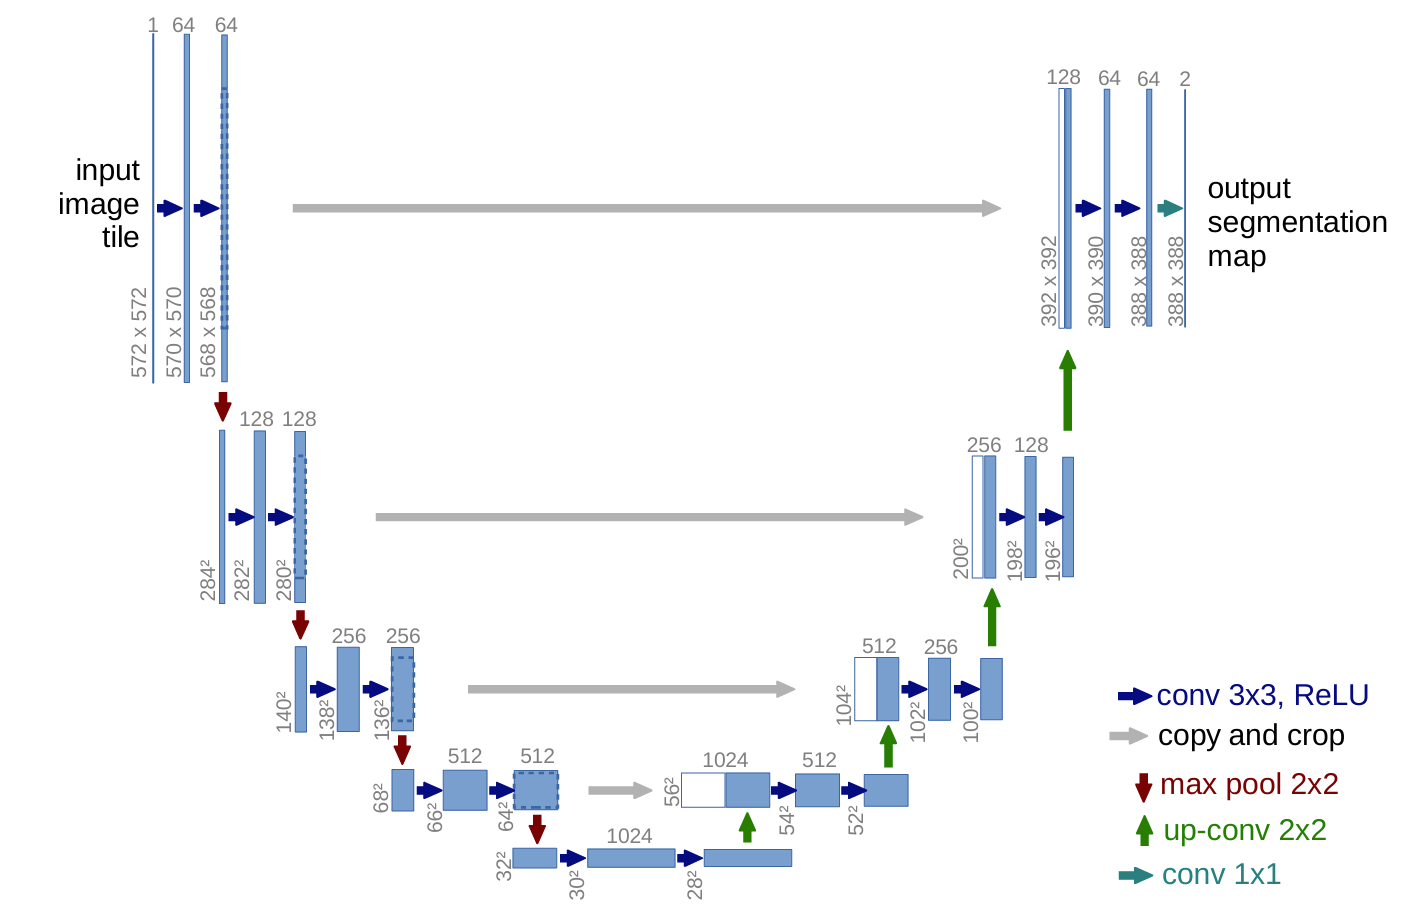

Image from the original u-net paper: https://arxiv.org/abs/1505.04597

In [10]:
#We will be defining the convolutional block
#This block will contain n_conv number of convolution layers, whose final layer downsamples the image resolution by 2 using strides
class conv_blocks(nn.Module):
    def __init__(self, in_channels, out_channels, stride, n_conv = 3, mid_channels = None):
        """
        n_conv*(conv --> batchnorm --> LeakyReLU)
        """
        super().__init__()
        mid_channels = mid_channels or out_channels
        def conv_block(in_ch, out_ch, strd):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=strd, padding = 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(inplace = True)
            )
        layers = [conv_block(in_channels, mid_channels, 1)]
        layers += [conv_block(mid_channels, mid_channels, 1) for _ in range(n_conv -2)]
        layers += [conv_block(mid_channels, out_channels, stride)]
        self.block = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.block(x)

In [11]:
#Now we define upsampling layer in the UNet.
#upsampling is done using convTranspose
#There is a number of convolution layers before each upsampling and the bottleneck.
class up_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(inplace = True)
        )
        def conv_block(in_ch, out_ch, strd):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=strd, padding = 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(inplace = True)
            )
        layers = []
        layers += [conv_block(in_channels, in_channels, 1) for _ in range(2)] #
        self.conv = nn.Sequential(*layers)
        

    def forward(self, x1, x2): #x2 is the skip connection from the encoder
        x1 = self.conv(x1)
        x1 = self.up(x1)
        
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.base_channel = cfg.base_channel
        self.in_channel = cfg.init_time_num #Initial input channels 
        self.out_channel = cfg.final_channel

        #The encoder block contains 3 conv blocks, we increase the number of channels by 2 as we downsize 
        self.encoder_block = nn.ModuleList([
            conv_blocks(self.in_channel, self.base_channel, stride = 2, n_conv = 3, mid_channels = self.base_channel), #Output shape (n, 64,128,128)
            conv_blocks(self.base_channel, 2*self.base_channel, stride = 2, n_conv = 3), #Output shape (n, 128,64,64)
            conv_blocks(2*self.base_channel, 4*self.base_channel, stride = 2, n_conv = 3, mid_channels = 2*self.base_channel) #Output shape (n, 256,32,32)
        ])
        
        #The decoder block (There are 3 blocks here)
        self.decoder_block = nn.ModuleList([
            up_layer(4*self.base_channel, 2*self.base_channel), #Output shape (n, 256,64,64)
            up_layer(4*self.base_channel, self.base_channel), #Output shape (n, 128, 128, 128)
            up_layer(2*self.base_channel, self.in_channel) #Output shape (n, input_time_steps, 256, 256)
        ])
    
        #The final output convolution, this will align the number of channels to the output
        self.final_conv = conv_blocks(2*self.in_channel, self.out_channel, stride = 1, n_conv = 3, mid_channels = self.base_channel) #Output shape (n, output_time_steps, 256, 256)
        self.activation = nn.Tanh()

    def forward(self, x):
        #print(f"Initial x is of shape {x.shape}")
        res = []
    
        for i, down in enumerate(self.encoder_block): 
            res.append(x)
            x = down(x)
            #print(f"During downsampling, x{i} is of shape {x.shape}")
    
        for i, up in enumerate(self.decoder_block):
            x2 = res.pop()
            x = up(x, x2)
            #print(f"During upsampling, x{i} is of shape {x.shape}")
        x = self.final_conv(x)
        #print(f"x final is of shape {x.shape}")
        return self.activation(x)

In [14]:
#We can visualize our outputs at each step, uncommenting the print functions is needed here
#mynet = UNet(cfg)
#x = torch.randn(5,cfg.init_time_num,256,256)
#x = mynet(x)

### Training

In [15]:
#Initializing the model parameters
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [16]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = UNet(self.cfg)
        self.model.apply(init_weights)
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def loss_function(self,y_true,y_hat, beta = 0.5):   
        #lp_norm = lambda x: torch.norm(x, p=2)

        #A gradient loss is added to capture possible edges
        grad_true_x = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_true_y = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]

        grad_pred_x = y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]
        grad_pred_y = y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]

        direct_loss = F.mse_loss(y_hat, y_true)
        return  direct_loss + beta*(F.mse_loss(grad_true_x, grad_pred_x) + F.mse_loss(grad_true_y, grad_pred_y))
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.loss_function(y,y_hat, beta = 0.5)
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]

    #For post_processing the data
    def denormalize(self, data, cfg):
        return (data + 1) / 2 * (cfg.data_max - cfg.data_min) + cfg.data_min


    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                y_hat_post = self.denormalize(y_hat, cfg)
                y_post = self.denormalize(y, cfg)
                predictions.append(y_hat_post.cpu())
                targets.append(y_post.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.loss_function(y,y_hat, beta = 0.5)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        seis_hat = torch.cat(predictions,dim =0); seis_true = torch.cat(targets,dim =0)
        print(f"Average Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, seis_hat, seis_true        

In [17]:
model = PlModel(cfg)

In [18]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'ns_unet-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 20,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\checkpoint_ns exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 4.7 M  | train
---------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.710    Total estimated model params size (MB)
99        Modules in train mode
0         Modules in eval mode


DataLoaded Successfully!!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Evaluation

In [19]:
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("ns_unet-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.predict_dataloader()

In [20]:
batch = next(iter(data_module.predict_dataloader()))
w_init, w_final = batch
pred = model(w_init.to(device))
print(pred.mean().item(), pred.std().item())
print(w_final.mean().item(), w_final.std().item())

0.04084668308496475 0.050958409905433655
0.017957115545868874 0.07845915108919144


In [21]:
avgloss, preds, exact = model.evaluate_on_test_set(pred_loader)

Average Loss on exact test set: 0.0024


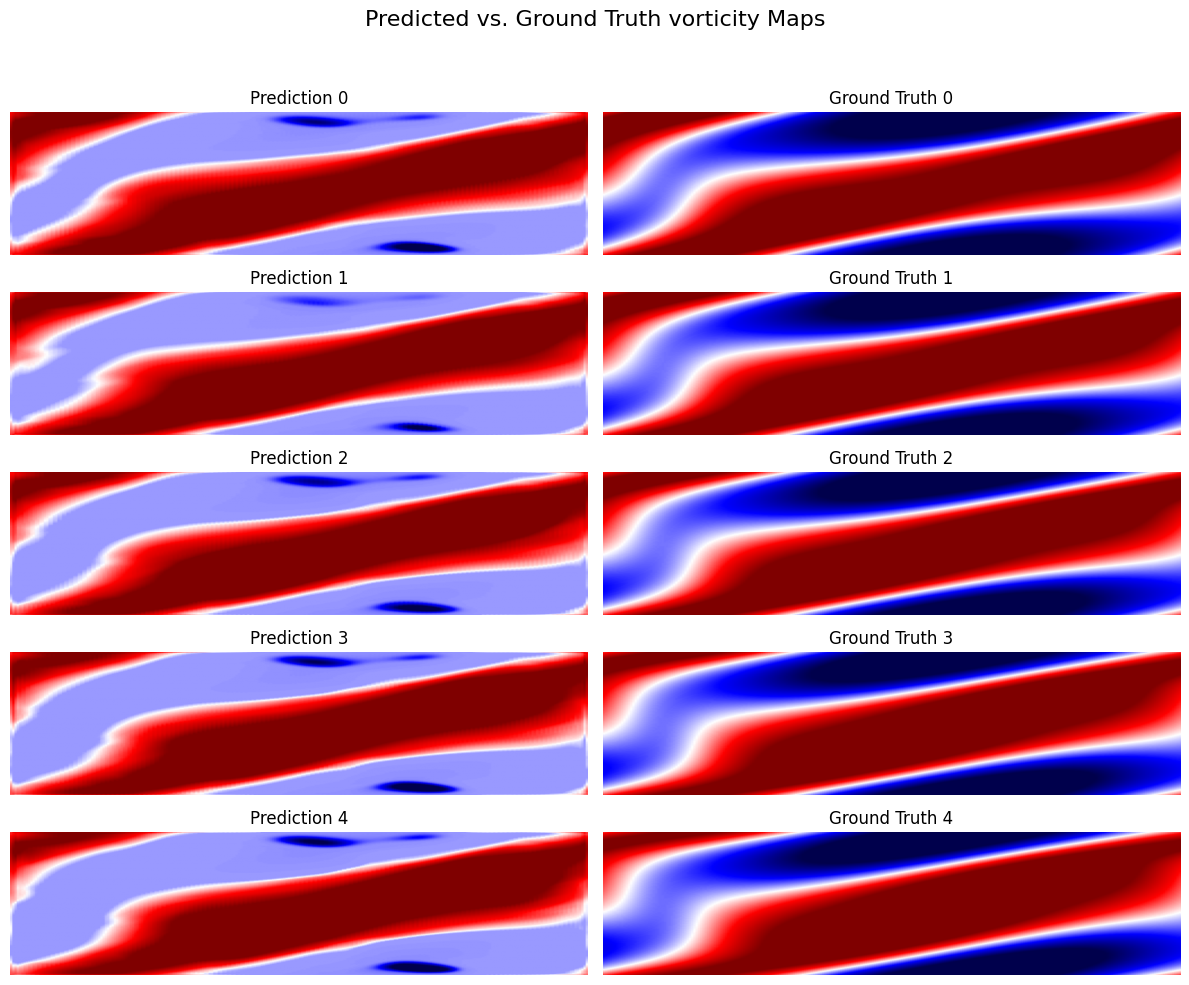

In [22]:
%matplotlib inline
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth vorticity Maps", fontsize=16)
n = 45
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[n, i, :, :], aspect='auto', cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[n, i, :, :], aspect='auto', cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [24]:
#Animated Visualization for a sample in time
%matplotlib qt

sample_idx = 45

u_pred = preds[sample_idx]    # Shape: (68, H, W)
u_exact = exact[sample_idx]   # Shape: (68, H, W)

# side-by-side figure setup
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im_pred = axs[0].imshow(u_pred[0], cmap='seismic', vmin=-1, vmax=1)
im_exact = axs[1].imshow(u_exact[0], cmap='seismic', vmin=-1, vmax=1)

axs[0].set_title("Prediction at time step 32")
axs[1].set_title("Exact at time step 32")

#fig.colorbar(im_pred, ax=axs[0])
fig.colorbar(im_exact, ax=axs[1])

# Animation loop
for i in range(u_pred.shape[0]):
    im_pred.set_data(u_pred[i])
    im_exact.set_data(u_exact[i])
    axs[0].set_title(f"Prediction at time step {32 + i}")
    axs[1].set_title(f"Exact at time step {32 + i}")
    plt.pause(0.05)

plt.show()
